# Brain Tumor MRI Data Exploration and Preprocessing

We explore and preprocess a brain tumor MRI dataset from Kaggle by visualizing raw images and then appropriate image  transformations (i.e., grayscale, resize, tensor conversion, and normalization) to prep the data.

In [ ]:
# Import libraries
import os
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import torchvision
import torchvision.transforms as transforms
from PIL import Image

# Set seed for reproducibility
random.seed(42)


In [2]:
# Download brain tumor MRI dataset from Kaggle
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

# List directories
if os.path.exists(path):
    print("Dataset directory contents:", os.listdir(path))
else:
    print("Dataset path does not exist!")

data_dir = pathlib.Path(path)

Path to dataset files: /Users/bengriffin/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1
Dataset directory contents: ['Training', 'Testing']


Let's display a random sample of images

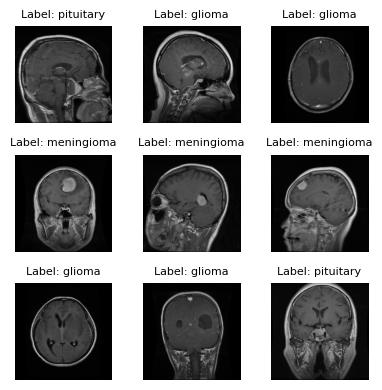

In [3]:
# Original dataset
train_set_orig = torchvision.datasets.ImageFolder(data_dir.joinpath('Training'), transform=None)

# Randomly sample from dataset
sample_indices = random.sample(range(len(train_set_orig)), 9)

# Plot examples
fig, axes = plt.subplots(3, 3, figsize=(4, 4))
for ax, idx in zip(axes.flatten(), sample_indices):
    img, label = train_set_orig[idx]
    img_np = np.array(img)
    ax.imshow(img_np)
    ax.set_title(f"Label: {train_set_orig.classes[label]}", fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [4]:
# Pick example image from dataset
idx = 4139
img, label = train_set_orig[idx]
img_np = np.array(img)

# Let's explore the example
print("Random image index:", idx)
print("Label:", train_set_orig.classes[label])
print("Image shape:", img_np.shape)
print("Data type:", img_np.dtype)
print("Pixel range:", img_np.min(), img_np.max())

Random image index: 4139
Label: notumor
Image shape: (168, 300, 3)
Data type: uint8
Pixel range: 0 255


Images appear to have 3 channels despite being greyscale, let's understand why..

In [5]:
# Let's see if the third channel is just duplicate info
channel0 = img_np[:, :, 0]
channel1 = img_np[:, :, 1]
channel2 = img_np[:, :, 2]
if np.array_equal(img_np[:, :, 0], img_np[:, :, 1]) and np.array_equal(img_np[:, :, 1], img_np[:, :, 2]):
    print("The three channels are duplicates (i.e., image is greyscale).")
else:
    print("The channels differ (the image is in color).")


The three channels are duplicates (i.e., image is greyscale).


**Transformation Pipeline Explanation**

- **Grayscale:**  
  Since the images have 3 channels but they are duplicates, then we simply convert to greyscale without losing information

- **Resize:**  
  Many of the images are different sizes e.g., above we have (168,300,3) so let's standardizes all images to 128x128 pixels for a consistent input size

- **ToTensor:**  
  Convert the image into a PyTorch tensor and scale pixel values between 0 and 1

- **Normalize:**  
  Centers and scales pixel values (subtracting 0.5 and dividing by 0.5) to stabilize model training


In [6]:
# Define Transformation Pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to greyscale (i.e., single channel)
    transforms.Resize((128,128)),                 # Resize images to 128x128 pixels
    transforms.ToTensor(),                        # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize pixel values
])

# Training dataset
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Training'), transform=transform)
# Testing dataset
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('Testing'), transform=transform)
print("Training dataset:", train_set)
print("Testing dataset:", val_set)
print("Number of training samples:", len(train_set))
print("Number of testing samples:", len(val_set))

Training dataset: Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /Users/bengriffin/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Training
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
Testing dataset: Dataset ImageFolder
    Number of datapoints: 1311
    Root location: /Users/bengriffin/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1/Testing
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )
Number of training samples: 5712
Number of testing samples: 1311


In [7]:
# Get class names from training set
classes = train_set_orig.classes

# Compute class counts for train/test
train_class_counts = [sum(1 for _, label in train_set if label == i) for i in range(len(classes))]
test_class_counts = [sum(1 for _, label in val_set if label == i) for i in range(len(classes))]

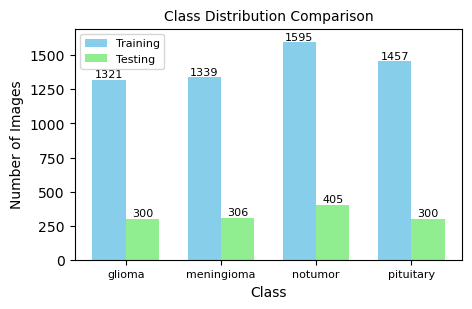

In [8]:
# Let's look at how many of each class we have for train/test
bar_width = 0.35
index = np.arange(len(classes))

plt.figure(figsize=(5, 3))
bars_train = plt.bar(index, train_class_counts, bar_width, label='Training', color='skyblue')
bars_test = plt.bar(index + bar_width, test_class_counts, bar_width, label='Testing', color='lightgreen')
for bar in bars_train:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=8)
for bar in bars_test:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom', fontsize=8)

plt.xlabel("Class", fontsize=10)
plt.ylabel("Number of Images", fontsize=10)
plt.title("Class Distribution Comparison", fontsize=10)
plt.xticks(index + bar_width/2, classes, fontsize=8)
plt.ylim(0, max(max(train_class_counts), max(test_class_counts)) + 100)
plt.legend(fontsize=8)
plt.show()

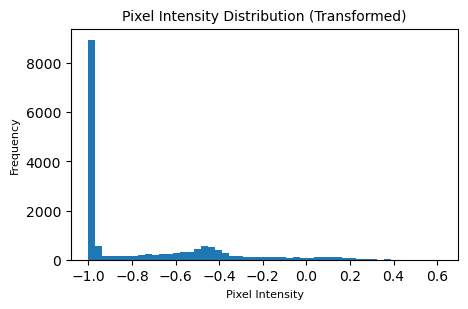

In [9]:
# Get an example transformed image from the training set and plot distribution of pixel intensities
plt.figure(figsize=(5, 3))
img_trans_example, _ = train_set[0]
plt.hist(img_trans_example.flatten().numpy(), bins=50)
plt.title("Pixel Intensity Distribution (Transformed)", fontsize=10)
plt.xlabel("Pixel Intensity", fontsize=8)
plt.ylabel("Frequency", fontsize=8)
plt.show()


This histogram shows the distribution of pixel intensities after applying our transformation pipeline (greyscale, resizing, normalization). Most pixel values are ~ -1.0 since our normalization subtracts 0.5 and divides by 0.5, i.e., they are around 0 in the original image, as we would expect for a lot of the outer pixels (i.e., outside the brain).

Next let's compare some of the original images to their transformed versions to check they are consistent.

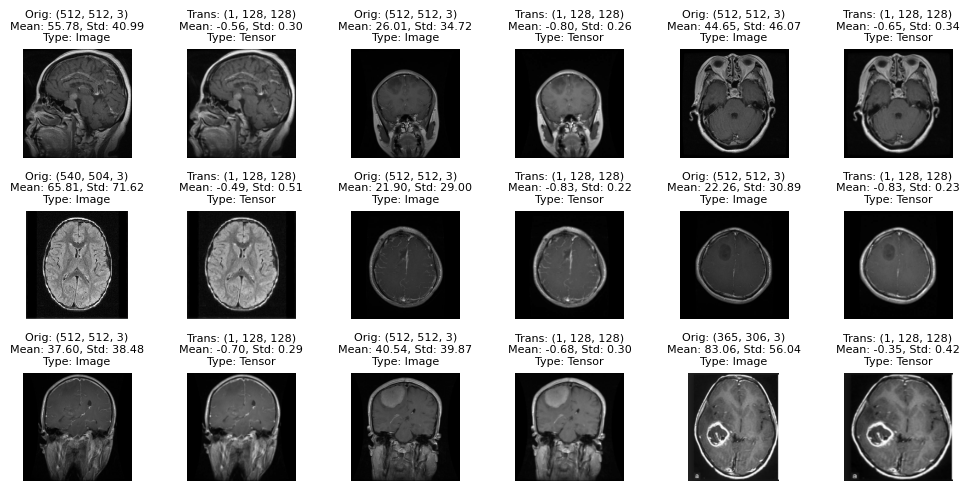

In [10]:
# Compare a random sample of original and transformed images, including some stats
sample_indices = random.sample(range(len(train_set_orig)), 9)
fig, axes = plt.subplots(3, 6, figsize=(10, 5))

for i, idx in enumerate(sample_indices):
    row = i // 3
    col = (i % 3) * 2
    
    # Open  original image
    img_path, _ = train_set_orig.imgs[idx]
    img_orig = Image.open(img_path).convert('RGB')
    img_orig_np = np.array(img_orig)
    orig_shape = img_orig_np.shape
    orig_mean = img_orig_np.mean()
    orig_std = img_orig_np.std()
    orig_type = type(img_orig)
    
    # Apply transformation
    img_trans = transform(img_orig)
    trans_shape = tuple(img_trans.shape)
    trans_mean = img_trans.mean().item()
    trans_std = img_trans.std().item()
    trans_type = type(img_trans)
    
    # Display original image
    axes[row, col].imshow(img_orig)
    axes[row, col].set_title(
        f"Orig: {orig_shape}\nMean: {orig_mean:.2f}, Std: {orig_std:.2f}\nType: {orig_type.__name__}",
        fontsize=8
    )
    axes[row, col].axis('off')
    
    # Display transformed image
    axes[row, col+1].imshow(img_trans.squeeze(), cmap="gray")
    axes[row, col+1].set_title(
        f"Trans: {trans_shape}\nMean: {trans_mean:.2f}, Std: {trans_std:.2f}\nType: {trans_type.__name__}",
        fontsize=8
    )
    axes[row, col+1].axis('off')

plt.tight_layout()
plt.show()


## Summary
The dataset comes with a pre-defined split of 5,712 training samples and 1,311 testing samples which seems reasonable for now and I believe should work with our deep learning approaches. However, we can keep an eye on model performance, and I believe adding some extra data augmentation steps might help improve model performance, so this may be worthwhile working on at some point. In terms of preprocessing, we converted the images to greyscale, resized them to 128x128 pixels for consistency across iamges, converted them into a PyTorch tensor, and then standardized the pixel intensities to ensure consistent inputs into the model.